# Tour of `rxn4chemistry`

In this quick tour we will explore the main features of `rxn4chemistry`, the python wrapper for [RXN for Chemistry](https://rxn.res.ibm.com).
For a full set of features check the [GitHub repo](https://github.com/rxn4chemistry/rxn4chemistry) and/or the [online documentation](https://rxn4chemistry.github.io/rxn4chemistry).

In [41]:
import logging
from typing import Dict, List
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import display

logging.basicConfig(level=logging.INFO, format='%(levelname)s : %(message)s')

def get_reaction_from_smiles(reaction_smiles: str) -> Chem.rdChemReactions.ChemicalReaction:
    return AllChem.ReactionFromSmarts(reaction_smiles, useSmiles=True)


def collect_reactions_from_retrosynthesis(tree: Dict) -> List[str]:
    reactions = []
    if 'children' in tree and len(tree['children']):
        reactions.append(
            AllChem.ReactionFromSmarts('{}>>{}'.format(
                '.'.join([node['smiles'] for node in tree['children']]),
                tree['smiles']
            ), useSmiles=True)
        )
    for node in tree['children']:
        reactions.extend(collect_reactions_from_retrosynthesis(node))
    return reactions

## Instantiating the wrapper

Setup the wrapper using a valid API key. You can get one on the IBM RXN website from [here](https://rxn.res.ibm.com/rxn/user/profile).

In [42]:
from rxn4chemistry import RXN4ChemistryWrapper
api_key = 'API_KEY'
rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)

You can also use a custom on-premise installation by controlling an environment variable:

```console
export RXN4CHEMISTRY_BASE_URL="https://some.other.rxn.server"
```

Or setting a different host in your python code:

```python
rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key, base_url='https://some.other.rxn.server')
# or set it afterwards
# rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)
# rxn4chemistry_wrapper.set_base_url('https://some.other.rxn.server')
```

## Create a project

Create a project, you can easily check the identifier associated to it in the response:

In [44]:
rxn4chemistry_wrapper.create_project('rxn4chemistry_tour')
print(f'Identifier for the project {rxn4chemistry_wrapper.project_id}')
# NOTE: you can create a project or set an esiting one using:
# rxn4chemistry_wrapper.set_project('6088fc284fe8920001a58546')

INFO : Set project id to 63e4b7de54f4ba001fea6e20


Identifier for the project 63e4b7de54f4ba001fea6e20


## Reaction prediction

RXN for Chemistry uses the Molecular Transformer as forward reaction prediction model (more details in the [paper](https://doi.org/10.1021/acscentsci.9b00576)).
![molecular_transformer](https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/acscii/2019/acscii.2019.5.issue-9/acscentsci.9b00576/20190918/images/medium/oc9b00576_0009.gif)

Running a reaction prediction is as simple as:

In [45]:
predict_reaction_response = rxn4chemistry_wrapper.predict_reaction(
    'BrBr.c1ccc2cc3ccccc3cc2c1'
)

**NOTE:** we have set limitations on the number of calls per second and per minute in the public version of RXN for Chemistry. These limits can be tweaked or removed in on-premise deployments. Those limitations are currently set to 5 calls per minute, in most cases this is not a problematic limitation.

In [46]:
predict_reaction_results = rxn4chemistry_wrapper.get_predict_reaction_results(
    predict_reaction_response['prediction_id']
)

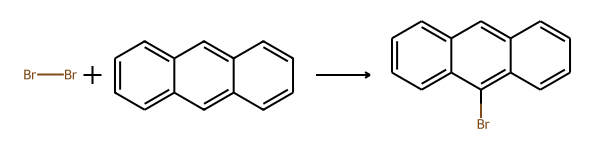

In [47]:
get_reaction_from_smiles(predict_reaction_results['response']['payload']['attempts'][0]['smiles'])

It is possible to run reaction prediction in batches (not storing the information in any project) to use the service in a highthroughput fashion:

In [50]:
predict_rection_batch_response = rxn4chemistry_wrapper.predict_reaction_batch(
    precursors_list=['BrBr.c1ccc2cc3ccccc3cc2c1', 'Cl.c1ccc2cc3ccccc3cc2c1']
)

Confidence: 0.9797951373863595


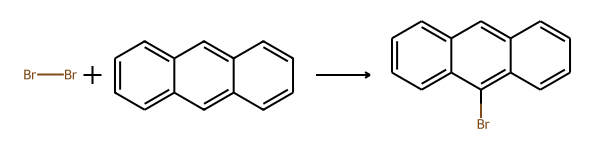

Confidence: 0.5872236848398613


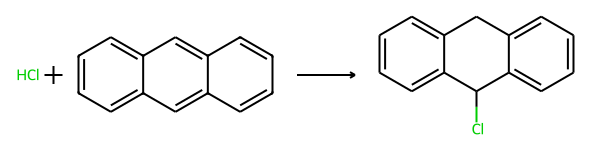

In [51]:
for reaction_prediction in rxn4chemistry_wrapper.get_predict_reaction_batch_results(
    predict_rection_batch_response['task_id']
)['predictions']:
    print(f'Confidence: {reaction_prediction["confidence"]}')
    display(get_reaction_from_smiles(reaction_prediction['smiles']))

It is also possible to predict multiple forward reaction prediction outcomes (in batch):

In [56]:
response = rxn4chemistry_wrapper.predict_reaction_batch_topn(
    precursors_lists=[
        ["BrBr", "c1ccc2cc3ccccc3cc2c1"],
        ["BrBr", "c1ccc2cc3ccccc3cc2c1CCO"],
        ["Cl", "CCC(=O)NCCC", "O"],
    ],
    topn=5,
)

In [57]:
result = rxn4chemistry_wrapper.get_predict_reaction_batch_topn_results(
    response["task_id"]
)

In [58]:
for i, reaction_predictions in enumerate(result['predictions'], 1):
    print(f'Outcomes for reaction no {i}:')
    for j, prediction in enumerate(reaction_predictions["results"], 1):
        product_smiles = ".".join(prediction["smiles"])
        confidence = prediction["confidence"]
        print(f'  Product(s) {j}: {product_smiles}, with confidence {confidence}')

Outcomes for reaction no 1:
  Product(s) 1: Brc1c2ccccc2cc2ccccc12, with confidence 0.9797950224106947
  Product(s) 2: Brc1c2ccccc2c(Br)c2ccccc12, with confidence 0.019042681110299945
  Product(s) 3: Brc1ccc2c(Br)c3ccccc3cc2c1, with confidence 0.0006598504791316417
  Product(s) 4: Brc1cccc2c(Br)c3ccccc3cc12, with confidence 0.00012699291250752286
  Product(s) 5: Brc1ccc2cc3ccccc3c(Br)c2c1, with confidence 7.923485611170519e-05
Outcomes for reaction no 2:
  Product(s) 1: BrCCc1cccc2c(Br)c3ccccc3cc12, with confidence 0.6499804363247736
  Product(s) 2: OCCc1cccc2c(Br)c3ccccc3cc12, with confidence 0.28018130620906134
  Product(s) 3: OCCc1cccc2c(Br)c3ccccc3c(Br)c12, with confidence 0.023935038169605453
  Product(s) 4: BrCCc1cccc2cc3ccccc3c(Br)c12, with confidence 0.0177432823325949
  Product(s) 5: BrCCc1cccc2c(Br)c3ccccc3c(Br)c12, with confidence 0.008218596399806776
Outcomes for reaction no 3:
  Product(s) 1: CCCN.Cl, with confidence 0.9115572572973942
  Product(s) 2: CCCN, with confidence

**NOTE:** the results for batch predictions are not stored permanently in our databases, so we strongly recommend to save them since they will expire.

## Actions from procedure description

RXN for Chemistry allows to extract machine-readable actions from textual description of chemical procedures (see details in the [paper](https://doi.org/10.1038/s41467-020-17266-6)).
![actions_from_procedure](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-020-17266-6/MediaObjects/41467_2020_17266_Fig3_HTML.png)

Extract the actions from a recipe:

In [59]:
actios_from_procedure_results = rxn4chemistry_wrapper.paragraph_to_actions(
    'To a stirred solution of '
    '7-(difluoromethylsulfonyl)-4-fluoro-indan-1-one (110 mg, '
    '0.42 mmol) in methanol (4 mL) was added sodium borohydride '
    '(24 mg, 0.62 mmol). The reaction mixture was stirred at '
    'ambient temperature for 1 hour.'
)

In [60]:
for index, action in enumerate(actios_from_procedure_results['actions'], 1):
    print(f'{index}. {action}')

1. MAKESOLUTION with 7-(difluoromethylsulfonyl)-4-fluoro-indan-1-one (110 mg, 0.42 mmol) and methanol (4 mL)
2. ADD SLN
3. ADD sodium borohydride (24 mg, 0.62 mmol)
4. STIR for 1 hour at ambient temperature


## Retrosynthesis route prediction

RXN for Chemistry uses an hyper-graph exploration approach informed by the Molecular Transfomer for backward and forward reaction prediction (for details see the [paper](https://doi.org/10.1039/C9SC05704H)).
![retrosynthesis_prediction](https://pubs.rsc.org/en/Image/Get?imageInfo.ImageType=GA&imageInfo.ImageIdentifier.ManuscriptID=C9SC05704H&imageInfo.ImageIdentifier.Year=2020)

Running a retrosynthesis is as easy as picking a molecule and calling a one-liner:

In [61]:
smiles = 'CC(=O)NC1=CC=C(Br)C=C1'
predict_automatic_retrosynthesis_response = rxn4chemistry_wrapper.predict_automatic_retrosynthesis(product=smiles)

Check the status of the retrosynthesis prediction:

In [69]:
predict_automatic_retrosynthesis_results = rxn4chemistry_wrapper.get_predict_automatic_retrosynthesis_results(
    predict_automatic_retrosynthesis_response['prediction_id']
)
predict_automatic_retrosynthesis_results['status']

'SUCCESS'

Upon 'SUCCESS' we can choose one of the returned retrosynthetic paths. The paths are sorted based on the scoring mechanism of the models:

Showing path 0 with confidence 1.0:


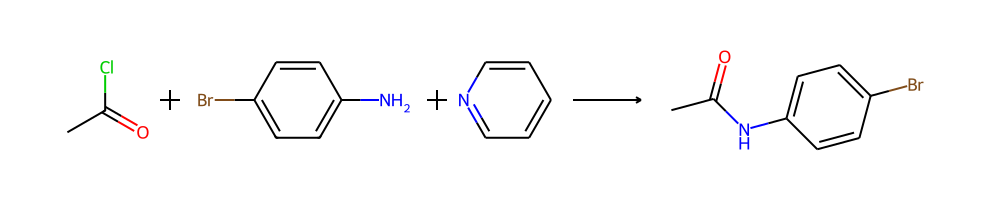

Showing path 1 with confidence 1.0:


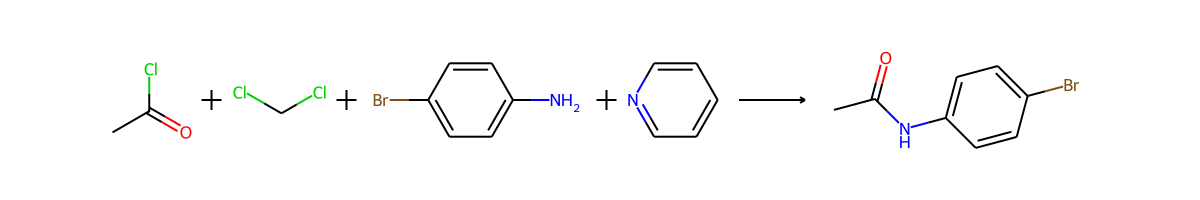

Showing path 2 with confidence 1.0:


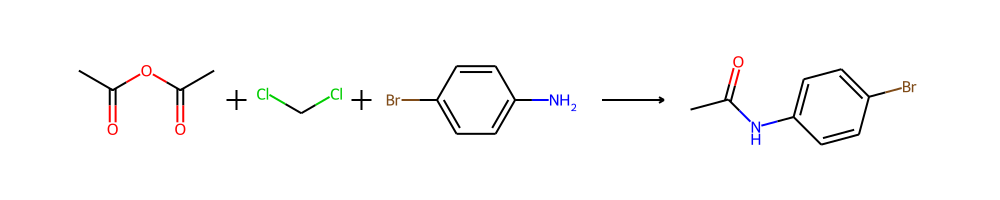

Showing path 3 with confidence 1.0:


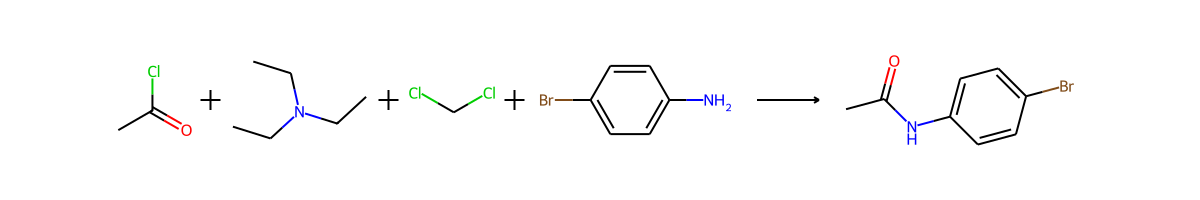

Showing path 4 with confidence 1.0:


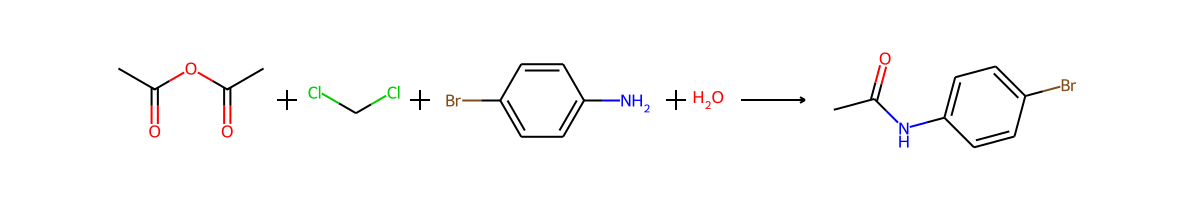

Showing path 5 with confidence 1.0:


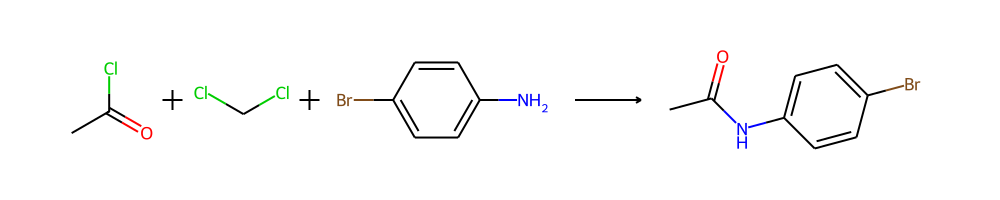

Showing path 6 with confidence 1.0:


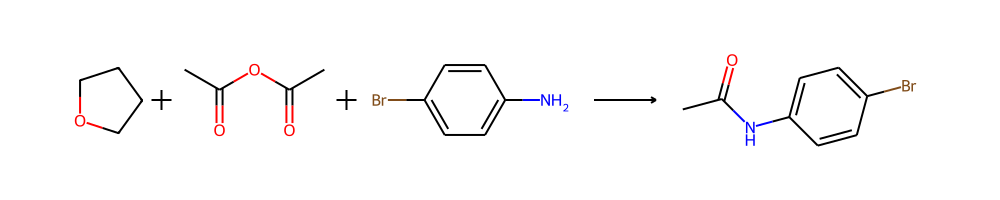

Showing path 7 with confidence 1.0:


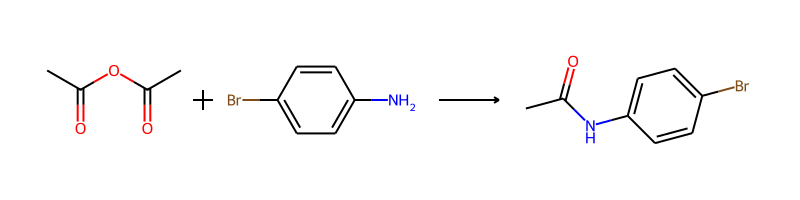

Showing path 8 with confidence 1.0:


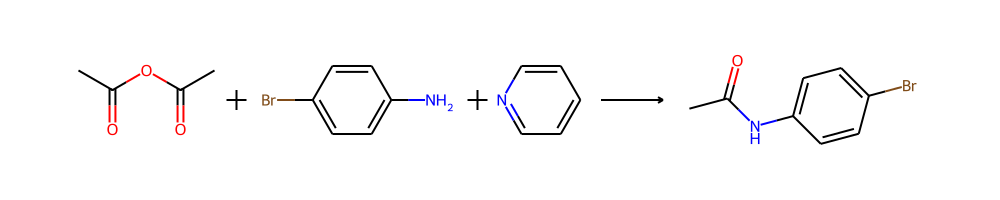

Showing path 9 with confidence 1.0:


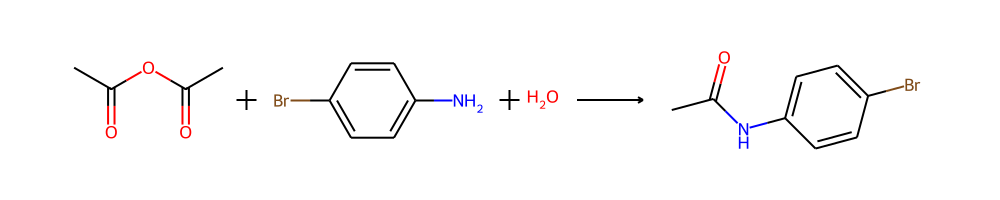

Showing path 10 with confidence 1.0:


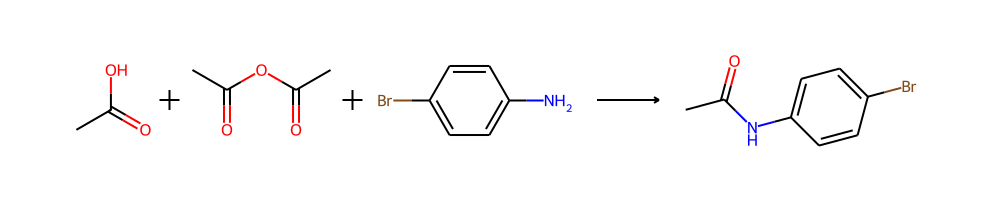

Showing path 11 with confidence 1.0:


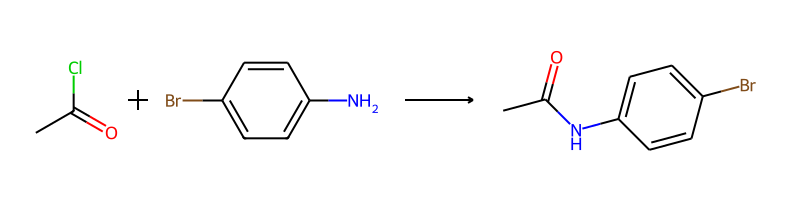

Showing path 12 with confidence 1.0:


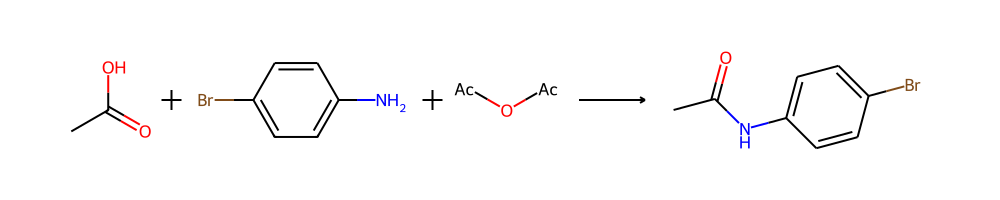

Showing path 13 with confidence 1.0:


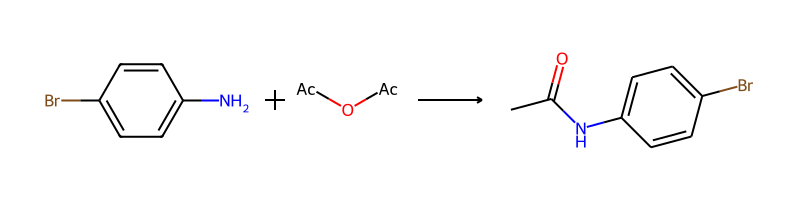

Showing path 14 with confidence 0.959:


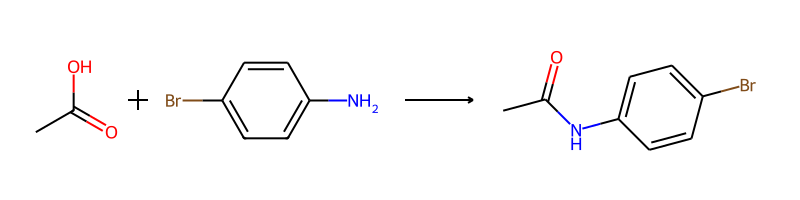

In [70]:
for index, tree in enumerate(predict_automatic_retrosynthesis_results['retrosynthetic_paths']):
    print('Showing path {} with confidence {}:'.format(index, tree['confidence']))
    for reaction in collect_reactions_from_retrosynthesis(tree):
        display(Chem.Draw.ReactionToImage(reaction))

## Perform a synthesis via [RoboRXN](https://rxn.res.ibm.com/roborxn) using one of the predict routes

Once a retrosynthesis prediction is performed we can predict a synthesis plan:

In [71]:
create_synthesis_from_sequence_response = rxn4chemistry_wrapper.create_synthesis_from_sequence(
    sequence_id=predict_automatic_retrosynthesis_results['retrosynthetic_paths'][1]['sequenceId']
)
print(f'Identifier for the synthesis: {create_synthesis_from_sequence_response["synthesis_id"]}')

Identifier for the synthesis: 63e4b81d54f4ba001fea6ed2


Inspect the actions predicted by the AI model (for details see [paper](https://doi.org/10.1038/s41467-021-22951-1)).
![smiles_to_actions](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-021-22951-1/MediaObjects/41467_2021_22951_Fig1_HTML.png)


In [72]:
import json
synthesis_id = create_synthesis_from_sequence_response['synthesis_id']
node_ids = rxn4chemistry_wrapper.get_node_ids(synthesis_id=synthesis_id)
node_id = node_ids[-1]

actions_and_product = rxn4chemistry_wrapper.get_reaction_settings(synthesis_id=synthesis_id, node_id=node_id)
node_actions, product = actions_and_product['actions'], actions_and_product['product']

for index, action in enumerate(node_actions, 1):
    print(f'Action {index}:\n{json.dumps(action, indent=2)}\n')

{'response': {'payload': {'id': '63e4b81d54f4ba001fea6ed2', 'metadata': {}, 'embed': {'createdBy': {'id': '53884a79-33fd-458a-8020-4a0019f61652', 'metadata': {}, 'embed': {}, 'computedFields': {}, 'createdOn': 1675928374810, 'createdBy': '53884a79-33fd-458a-8020-4a0019f61652', 'modifiedOn': 1675928532687, 'modifiedBy': '53884a79-33fd-458a-8020-4a0019f61652', 'extId': '9db808c5-6cb2-4e60-88f4-334e04b11686', 'blocked': False, 'role': None, 'email': 'oli@zurich.ibm.com', 'name': None, 'fullName': 'oli schilter', 'company': None, 'firstName': None, 'lastName': None, 'provider': 'cloud_directory', 'picture': None, 'locale': None, 'sub': '53884a79-33fd-458a-8020-4a0019f61652', 'istitution': None, 'apiKey': 'apk-460948935d698865518845c111a4633b93c1b57c9faba4d22e34e3135ae3f5fa5c7b7c16d1b799b266aa22b1ad6ae904a24ba2432a858cfe1917ed295d1e328e601543129012419191b1a103547ce7ef', 'roboRxnApiKey': 'z7WcYzqPGEcFW.iY2VUA7hvzTs4', 'roboRxnApiKeyType': 'simulator', 'groupId': '602635f330ea030001576d9e', '

The adding acetyl chloride acction needs ot be changed to not adding it dropwise since solids are added in pins and we remove the purify actions since it is currently not supported on the robotic hardware


In [73]:
# update the the action so the solid is not added dropwise
node_actions[3]['content']['dropwise']['value'] = False

# remove the purify action 
node_actions.pop(11)

# update the node actions
rxn4chemistry_wrapper.update_reaction_settings(synthesis_id=synthesis_id, node_id=node_id, actions=node_actions, product=product)


{'response': {'payload': {'product': {'moleculeInfo': {'density': 997.77,
     'molecularWeight': 214.06199999999998,
     'name': 'N-(4-bromophenyl)acetamide'},
    'productMassAndReactionInformation': {'unit': 'mg',
     'quantity': 500,
     'securityFactor': 1.1,
     'stoichiometryFactor': 1.0,
     'yield': 0.9}},
   'actions': [{'name': 'add',
     'messages': [{'shortMessage': 'Valid action',
       'type': 'info',
       'longMessage': 'Successful validation for action Add.'}],
     'content': {'atmosphere': None,
      'duration': None,
      'compatible_solvent': None,
      'material': {'value': '4-bromoaniline',
       'quantity': {'value': 0.5, 'unit': 'mmol'},
       'unit': '',
       'stoichiometryFactor': 1.0,
       'smiles': None,
       'feasibleUnits': ['ml'],
       'isChanged': {'unit': False,
        'quantity': {'value': False, 'unit': False},
        'value': False,
        'stoichiometryFactor': False},
       'isMissingMaterial': True},
      'dropwise': {'

Start the synthesis and follow its status:

In [74]:
synthesis_execution = rxn4chemistry_wrapper.start_synthesis(
    synthesis_id=create_synthesis_from_sequence_response['synthesis_id']
)
synthesis_execution['synthesis_execution_id']

'63e4b86b54f4ba001fea6efe'

In [77]:
synthesis_status_result = rxn4chemistry_wrapper.get_synthesis_status(
    synthesis_id=synthesis_execution['synthesis_execution_id']
)
synthesis_status_result['status']

'WAITING'

For fine-grained live updates check the progress on [RXN for Chemistry](https://rxn.res.ibm.com/rxn) under the RoboRXN section.